By Abhijaat Sidher

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision.utils as utils
import copy

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ml_library as ML

In [3]:
history = {
    'model': str,
    'batch_size': int,
    'num_workers': int,
    'learning_rate': float,
    'momentum': None,
    'optimizer': str,
    'training_loss': [],
    'validation_loss': [],
    'training_accuracy': [],
    'validation_accuracy': []
}

In the data there are four classes of scans: Healthy, CNV, DME and DRUSEN. The last three are eye diseases that cause visible damage to the retina and can be spotted through the OCT scans.

In [4]:
classes = [0, 1, 2, 3]
class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [5]:
path_to_data = 'data/'
path_train = path_to_data + 'train'
path_test = path_to_data + 'test'
path_val = path_to_data + 'val'

Source:

- [1] https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

**First Step:** Load the Data, setup Transforms, and Initialize the Dataloader

In [6]:
size = (224, 224)

# Transforms for train set
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=size, antialias=True),
    # v2.Resize(size=size),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomVerticalFlip(p=0.5),
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # v2.ElasticTransform(),
    # v2.RandomRotation(degrees=(30, 70)),
    v2.ToTensor(),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1977, 0.1977, 0.1977], std=[0.1048, 0.1048, 0.1048]),
])

# Transforms for test/val set
test_val_transform = v2.Compose([
    v2.Resize(size=(256,256)),
    v2.CenterCrop(size=size),
    v2.ToTensor(),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1977, 0.1977, 0.1977], std=[0.1048, 0.1048, 0.1048]),
])

/root/miniconda3/envs/uECE189A/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
dataset_train = ImageFolder(root=path_train, transform=train_transform)
dataset_test = ImageFolder(root=path_test, transform=test_val_transform)
dataset_val = ImageFolder(root=path_val, transform=test_val_transform)

In [8]:
# Batch Size
batch_size = 32

# Number of workers
num_workers = 4

In [9]:
#Initialize dataloader for train set
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle=True, 
#                                              pin_memory = True,
#                                              num_workers=num_workers,
#                                              persistent_workers=True)

#Initialize dataloader for test set
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size, shuffle=False)

#Initialize dataloader for val set
# val_loader = torch.utils.data.DataLoader(dataset_val, batch_size = batch_size, shuffle=True)

kfold_dataset = torch.utils.data.ConcatDataset([dataset_train, dataset_val])

0 torch.Size([32, 3, 224, 224]) torch.Size([32])
1 torch.Size([32, 3, 224, 224]) torch.Size([32])
2 torch.Size([32, 3, 224, 224]) torch.Size([32])
3 torch.Size([32, 3, 224, 224]) torch.Size([32])
4 torch.Size([32, 3, 224, 224]) torch.Size([32])
5 torch.Size([32, 3, 224, 224]) torch.Size([32])
6 torch.Size([32, 3, 224, 224]) torch.Size([32])
7 torch.Size([32, 3, 224, 224]) torch.Size([32])
8 torch.Size([32, 3, 224, 224]) torch.Size([32])
9 torch.Size([32, 3, 224, 224]) torch.Size([32])
10 torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


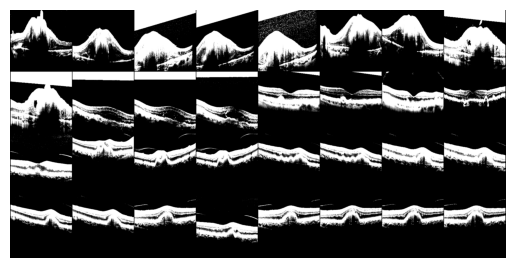

In [10]:
# Helper function to show a batch
def show_batch(sample_batched):
    images_batch, labels_batch = \
            sample_batched[0], sample_batched[1]

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    print(' '.join('%d' % labels_batch[j] for j in range(batch_size)))

for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())

    # observe 11th batch and stop.
    if i_batch == 10:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()

        
        break

In [11]:
images_batch, labels_batch = \
            sample_batched[0], sample_batched[1]

**Second Step:** Design Model's Architecture.



In [12]:
torch.manual_seed(0)

# Instantiate Pretrained ResNet
model = models.resnet152()
# model = models.resnet50()
# model = models.resnet18()

# Modify final layer
model.fc = nn.Linear(in_features=2048, out_features=(len(classes)), bias=True)
# model.fc = nn.Linear(in_features=512, out_features=(len(classes)), bias=True)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# View Model to validate
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Third Step:** Code Fit and Test functions.

Defined in `ml_library.py`.

**Fourth Step:** Set Parameters and run model.


In [13]:
# Define Parameters
num_epochs = 40
lr = 0.0001
momentum = 0.9
hist = copy.deepcopy(history)

In [14]:
# Define Loss Fuction
loss_function = nn.CrossEntropyLoss()

# Define Optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# hist['momentum'] = momentum
hist['optimizer'] = 'Adam'

hist['model'] = 'ResNet50'
hist['batch_size'] = batch_size
hist['num_workers'] = num_workers
hist['learning_rate'] = lr

In [15]:
# hist = ML.train(model=model, loss_fn=loss_function, optimizer=optimizer, 
#                 train_loader=train_loader, test_loader=val_loader, num_epochs=num_epochs,
#                 device = device, history=hist)

In [16]:
# Train model with K-Fold Cross Validation
k_folds = 10

hist = ML.kFoldCrossValTrain(model=model, loss_fn=loss_function, optimizer=optimizer, dataset=kfold_dataset, num_epochs=num_epochs, k_folds=k_folds, device=device, history=hist)

FOLD 0
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 1.4089., Validation Loss: 1.5279., Training Accuracy: 28.06 %, Validation Accuracy: 26.24 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 1.5413., Validation Loss: 1.4968., Training Accuracy: 38.41 %, Validation Accuracy: 36.18 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 1.3261., Validation Loss: 1.3418., Training Accuracy: 41.46 %, Validation Accuracy: 39.56 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.9790., Validation Loss: 1.1083., Training Accuracy: 53.49 %, Validation Accuracy: 48.51 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.9020., Validation Loss: 0.9976., Training Accuracy: 56.44 %, Validation Accuracy: 55.67 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.7818., Validation Loss: 1.0306., Training Accuracy: 60.24 %, Validation Accuracy: 57.46 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 1.1665., Validation Loss: 0.9135., Training Accuracy: 65.28 %, Validation Accuracy: 62.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.7538., Validation Loss: 0.9351., Training Accuracy: 65.99 %, Validation Accuracy: 61.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 1.0415., Validation Loss: 0.9347., Training Accuracy: 68.05 %, Validation Accuracy: 67.00 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.8779., Validation Loss: 0.8794., Training Accuracy: 70.21 %, Validation Accuracy: 69.58 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 1.6633., Validation Loss: 0.7675., Training Accuracy: 71.23 %, Validation Accuracy: 66.80 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.7517., Validation Loss: 0.8534., Training Accuracy: 73.44 %, Validation Accuracy: 70.97 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.5239., Validation Loss: 0.5634., Training Accuracy: 80.43 %, Validation Accuracy: 78.33 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.9014., Validation Loss: 0.6936., Training Accuracy: 76.98 %, Validation Accuracy: 74.16 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.3137., Validation Loss: 0.6382., Training Accuracy: 78.00 %, Validation Accuracy: 70.38 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.6978., Validation Loss: 0.6879., Training Accuracy: 78.00 %, Validation Accuracy: 77.34 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 1.2312., Validation Loss: 0.5633., Training Accuracy: 81.73 %, Validation Accuracy: 78.33 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.3303., Validation Loss: 0.5213., Training Accuracy: 83.15 %, Validation Accuracy: 79.13 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 1.5678., Validation Loss: 0.4825., Training Accuracy: 83.68 %, Validation Accuracy: 82.11 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.4296., Validation Loss: 0.4361., Training Accuracy: 83.10 %, Validation Accuracy: 82.90 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.3490., Validation Loss: 0.4494., Training Accuracy: 85.63 %, Validation Accuracy: 82.70 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.3356., Validation Loss: 0.4709., Training Accuracy: 85.34 %, Validation Accuracy: 82.90 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.8198., Validation Loss: 0.5320., Training Accuracy: 83.88 %, Validation Accuracy: 81.51 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.4292., Validation Loss: 0.4975., Training Accuracy: 84.56 %, Validation Accuracy: 82.50 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.5628., Validation Loss: 0.3963., Training Accuracy: 86.09 %, Validation Accuracy: 83.30 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.5563., Validation Loss: 0.5181., Training Accuracy: 83.72 %, Validation Accuracy: 82.11 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.2232., Validation Loss: 0.4703., Training Accuracy: 84.65 %, Validation Accuracy: 82.70 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 1.1066., Validation Loss: 0.4974., Training Accuracy: 82.33 %, Validation Accuracy: 81.11 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.7082., Validation Loss: 0.4221., Training Accuracy: 86.67 %, Validation Accuracy: 83.70 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.1535., Validation Loss: 0.4232., Training Accuracy: 85.74 %, Validation Accuracy: 86.68 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.3961., Validation Loss: 0.4167., Training Accuracy: 87.20 %, Validation Accuracy: 86.28 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.4654., Validation Loss: 0.3867., Training Accuracy: 86.64 %, Validation Accuracy: 83.70 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.5732., Validation Loss: 0.3936., Training Accuracy: 85.74 %, Validation Accuracy: 87.08 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.5056., Validation Loss: 0.4895., Training Accuracy: 84.25 %, Validation Accuracy: 80.52 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.3810., Validation Loss: 0.4392., Training Accuracy: 87.09 %, Validation Accuracy: 83.50 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.2522., Validation Loss: 0.3740., Training Accuracy: 88.28 %, Validation Accuracy: 83.90 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.5561., Validation Loss: 0.4248., Training Accuracy: 86.69 %, Validation Accuracy: 83.50 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.2205., Validation Loss: 0.4106., Training Accuracy: 87.17 %, Validation Accuracy: 85.69 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.1834., Validation Loss: 0.3955., Training Accuracy: 86.80 %, Validation Accuracy: 86.48 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.3024., Validation Loss: 0.3434., Training Accuracy: 89.08 %, Validation Accuracy: 85.88 %
--------------------------------------
FOLD 1
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.1755., Validation Loss: 0.2941., Training Accuracy: 88.66 %, Validation Accuracy: 88.47 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.2989., Validation Loss: 0.2929., Training Accuracy: 88.81 %, Validation Accuracy: 89.66 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.0353., Validation Loss: 0.3235., Training Accuracy: 88.92 %, Validation Accuracy: 90.06 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.2831., Validation Loss: 0.3162., Training Accuracy: 86.71 %, Validation Accuracy: 85.88 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.5277., Validation Loss: 0.2604., Training Accuracy: 90.11 %, Validation Accuracy: 88.07 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.7061., Validation Loss: 0.3130., Training Accuracy: 89.03 %, Validation Accuracy: 85.49 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.0481., Validation Loss: 0.2631., Training Accuracy: 89.72 %, Validation Accuracy: 90.06 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.2591., Validation Loss: 0.2832., Training Accuracy: 89.39 %, Validation Accuracy: 88.67 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.3055., Validation Loss: 0.3217., Training Accuracy: 89.23 %, Validation Accuracy: 88.07 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 1.4418., Validation Loss: 0.3205., Training Accuracy: 88.97 %, Validation Accuracy: 87.87 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.5235., Validation Loss: 0.2478., Training Accuracy: 90.14 %, Validation Accuracy: 89.66 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.1101., Validation Loss: 0.3191., Training Accuracy: 88.10 %, Validation Accuracy: 87.67 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.6216., Validation Loss: 0.3905., Training Accuracy: 87.33 %, Validation Accuracy: 89.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.2251., Validation Loss: 0.2534., Training Accuracy: 90.82 %, Validation Accuracy: 89.46 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.3814., Validation Loss: 0.2752., Training Accuracy: 90.05 %, Validation Accuracy: 89.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.3122., Validation Loss: 0.3143., Training Accuracy: 90.31 %, Validation Accuracy: 89.86 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.3196., Validation Loss: 0.3276., Training Accuracy: 88.30 %, Validation Accuracy: 87.87 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.4847., Validation Loss: 0.2316., Training Accuracy: 91.26 %, Validation Accuracy: 89.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.2408., Validation Loss: 0.2341., Training Accuracy: 90.69 %, Validation Accuracy: 89.86 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.9140., Validation Loss: 0.2995., Training Accuracy: 89.52 %, Validation Accuracy: 88.07 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.2313., Validation Loss: 0.2530., Training Accuracy: 91.11 %, Validation Accuracy: 90.66 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.2939., Validation Loss: 0.1961., Training Accuracy: 90.98 %, Validation Accuracy: 90.06 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.2229., Validation Loss: 0.3462., Training Accuracy: 89.39 %, Validation Accuracy: 90.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 1.2861., Validation Loss: 0.2898., Training Accuracy: 90.00 %, Validation Accuracy: 88.87 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.4736., Validation Loss: 0.2140., Training Accuracy: 91.00 %, Validation Accuracy: 90.66 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.3567., Validation Loss: 0.2393., Training Accuracy: 91.33 %, Validation Accuracy: 89.86 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.4931., Validation Loss: 0.3109., Training Accuracy: 87.93 %, Validation Accuracy: 88.47 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.1355., Validation Loss: 0.2667., Training Accuracy: 91.18 %, Validation Accuracy: 91.45 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.0372., Validation Loss: 0.2528., Training Accuracy: 91.73 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.0729., Validation Loss: 0.3217., Training Accuracy: 89.78 %, Validation Accuracy: 87.87 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.1364., Validation Loss: 0.2530., Training Accuracy: 91.84 %, Validation Accuracy: 90.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.0430., Validation Loss: 0.3511., Training Accuracy: 90.87 %, Validation Accuracy: 89.86 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.3457., Validation Loss: 0.2639., Training Accuracy: 90.27 %, Validation Accuracy: 89.66 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.1158., Validation Loss: 0.2426., Training Accuracy: 91.97 %, Validation Accuracy: 90.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.4766., Validation Loss: 0.2661., Training Accuracy: 91.86 %, Validation Accuracy: 87.08 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.1089., Validation Loss: 0.2332., Training Accuracy: 91.09 %, Validation Accuracy: 89.46 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.0819., Validation Loss: 0.2862., Training Accuracy: 90.71 %, Validation Accuracy: 89.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.3797., Validation Loss: 0.2422., Training Accuracy: 90.49 %, Validation Accuracy: 88.87 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.0349., Validation Loss: 0.2591., Training Accuracy: 91.09 %, Validation Accuracy: 91.65 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.4405., Validation Loss: 0.2604., Training Accuracy: 91.38 %, Validation Accuracy: 91.05 %
--------------------------------------
FOLD 2
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.0973., Validation Loss: 0.4557., Training Accuracy: 79.23 %, Validation Accuracy: 81.31 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.3030., Validation Loss: 0.2649., Training Accuracy: 90.31 %, Validation Accuracy: 90.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.2065., Validation Loss: 0.1570., Training Accuracy: 91.29 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.3852., Validation Loss: 0.1958., Training Accuracy: 92.57 %, Validation Accuracy: 91.65 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.8199., Validation Loss: 0.2682., Training Accuracy: 91.33 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.0408., Validation Loss: 0.2089., Training Accuracy: 91.62 %, Validation Accuracy: 92.45 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.4335., Validation Loss: 0.2573., Training Accuracy: 89.96 %, Validation Accuracy: 92.25 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.3311., Validation Loss: 0.2607., Training Accuracy: 92.37 %, Validation Accuracy: 91.45 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.2325., Validation Loss: 0.1794., Training Accuracy: 91.64 %, Validation Accuracy: 90.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.3921., Validation Loss: 0.1898., Training Accuracy: 92.13 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.0106., Validation Loss: 0.2523., Training Accuracy: 91.64 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.3109., Validation Loss: 0.2324., Training Accuracy: 91.13 %, Validation Accuracy: 90.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.1660., Validation Loss: 0.3036., Training Accuracy: 88.52 %, Validation Accuracy: 88.47 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.4144., Validation Loss: 0.2286., Training Accuracy: 91.38 %, Validation Accuracy: 90.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.1261., Validation Loss: 0.2353., Training Accuracy: 92.22 %, Validation Accuracy: 92.25 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.1760., Validation Loss: 0.1717., Training Accuracy: 92.66 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.0442., Validation Loss: 0.1969., Training Accuracy: 92.19 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.0379., Validation Loss: 0.1868., Training Accuracy: 93.03 %, Validation Accuracy: 93.44 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.1857., Validation Loss: 0.1617., Training Accuracy: 92.26 %, Validation Accuracy: 90.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.0470., Validation Loss: 0.2062., Training Accuracy: 92.44 %, Validation Accuracy: 90.06 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.1842., Validation Loss: 0.2335., Training Accuracy: 92.68 %, Validation Accuracy: 92.45 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.2949., Validation Loss: 0.1544., Training Accuracy: 92.68 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.0983., Validation Loss: 0.1506., Training Accuracy: 92.17 %, Validation Accuracy: 91.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.1482., Validation Loss: 0.1856., Training Accuracy: 92.72 %, Validation Accuracy: 92.25 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.4421., Validation Loss: 0.2092., Training Accuracy: 93.50 %, Validation Accuracy: 93.44 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.1422., Validation Loss: 0.1560., Training Accuracy: 93.17 %, Validation Accuracy: 91.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.1145., Validation Loss: 0.2061., Training Accuracy: 92.68 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.1288., Validation Loss: 0.2244., Training Accuracy: 92.66 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.5267., Validation Loss: 0.2075., Training Accuracy: 92.06 %, Validation Accuracy: 91.25 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.4642., Validation Loss: 0.1970., Training Accuracy: 92.46 %, Validation Accuracy: 91.65 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.3174., Validation Loss: 0.2785., Training Accuracy: 91.69 %, Validation Accuracy: 89.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.3049., Validation Loss: 0.1836., Training Accuracy: 93.43 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.0238., Validation Loss: 0.2257., Training Accuracy: 92.70 %, Validation Accuracy: 90.66 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.0200., Validation Loss: 0.1831., Training Accuracy: 93.03 %, Validation Accuracy: 93.44 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.1042., Validation Loss: 0.2002., Training Accuracy: 93.68 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.4116., Validation Loss: 0.1762., Training Accuracy: 92.86 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.3464., Validation Loss: 0.1944., Training Accuracy: 92.70 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.7121., Validation Loss: 0.2071., Training Accuracy: 92.15 %, Validation Accuracy: 93.24 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.0892., Validation Loss: 0.1945., Training Accuracy: 92.61 %, Validation Accuracy: 89.66 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.1172., Validation Loss: 0.2067., Training Accuracy: 92.37 %, Validation Accuracy: 88.47 %
--------------------------------------
FOLD 3
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.0308., Validation Loss: 0.2247., Training Accuracy: 91.99 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.1802., Validation Loss: 0.1160., Training Accuracy: 92.90 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.9444., Validation Loss: 0.1661., Training Accuracy: 93.63 %, Validation Accuracy: 95.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.1633., Validation Loss: 0.1629., Training Accuracy: 94.27 %, Validation Accuracy: 95.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.1288., Validation Loss: 0.2083., Training Accuracy: 92.37 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.0424., Validation Loss: 0.2333., Training Accuracy: 91.64 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.1652., Validation Loss: 0.1963., Training Accuracy: 92.30 %, Validation Accuracy: 91.45 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.0973., Validation Loss: 0.1754., Training Accuracy: 93.94 %, Validation Accuracy: 94.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.0466., Validation Loss: 0.2175., Training Accuracy: 92.28 %, Validation Accuracy: 91.45 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.0475., Validation Loss: 0.1850., Training Accuracy: 92.95 %, Validation Accuracy: 94.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.0861., Validation Loss: 0.1633., Training Accuracy: 93.39 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.6225., Validation Loss: 0.1593., Training Accuracy: 93.72 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.1706., Validation Loss: 0.1374., Training Accuracy: 93.37 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.0094., Validation Loss: 0.1514., Training Accuracy: 92.37 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.4015., Validation Loss: 0.1995., Training Accuracy: 92.75 %, Validation Accuracy: 91.25 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.1493., Validation Loss: 0.2006., Training Accuracy: 93.48 %, Validation Accuracy: 94.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.1750., Validation Loss: 0.2120., Training Accuracy: 92.72 %, Validation Accuracy: 89.26 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.1278., Validation Loss: 0.1530., Training Accuracy: 93.76 %, Validation Accuracy: 94.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.5115., Validation Loss: 0.2208., Training Accuracy: 92.86 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.3206., Validation Loss: 0.1666., Training Accuracy: 93.19 %, Validation Accuracy: 93.44 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.1272., Validation Loss: 0.1721., Training Accuracy: 94.21 %, Validation Accuracy: 94.83 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.1709., Validation Loss: 0.1776., Training Accuracy: 93.52 %, Validation Accuracy: 91.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.0080., Validation Loss: 0.1436., Training Accuracy: 93.98 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.8454., Validation Loss: 0.2007., Training Accuracy: 91.73 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.4995., Validation Loss: 0.1897., Training Accuracy: 93.19 %, Validation Accuracy: 91.25 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.0745., Validation Loss: 0.1697., Training Accuracy: 93.14 %, Validation Accuracy: 93.44 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.0234., Validation Loss: 0.1461., Training Accuracy: 94.16 %, Validation Accuracy: 94.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.2927., Validation Loss: 0.1546., Training Accuracy: 93.81 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.1144., Validation Loss: 0.1633., Training Accuracy: 92.75 %, Validation Accuracy: 94.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.2704., Validation Loss: 0.1778., Training Accuracy: 93.83 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.4052., Validation Loss: 0.1820., Training Accuracy: 94.23 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.1319., Validation Loss: 0.1788., Training Accuracy: 93.45 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.0831., Validation Loss: 0.1801., Training Accuracy: 94.25 %, Validation Accuracy: 94.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.1601., Validation Loss: 0.1589., Training Accuracy: 93.94 %, Validation Accuracy: 93.24 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.3623., Validation Loss: 0.1406., Training Accuracy: 94.54 %, Validation Accuracy: 94.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.3563., Validation Loss: 0.1291., Training Accuracy: 94.12 %, Validation Accuracy: 94.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.0555., Validation Loss: 0.1382., Training Accuracy: 93.76 %, Validation Accuracy: 91.65 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.1510., Validation Loss: 0.1951., Training Accuracy: 93.65 %, Validation Accuracy: 93.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.3299., Validation Loss: 0.1903., Training Accuracy: 93.50 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.0052., Validation Loss: 0.1535., Training Accuracy: 94.74 %, Validation Accuracy: 94.04 %
--------------------------------------
FOLD 4
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.0133., Validation Loss: 0.1206., Training Accuracy: 94.21 %, Validation Accuracy: 95.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.2199., Validation Loss: 0.1453., Training Accuracy: 93.92 %, Validation Accuracy: 95.03 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.3940., Validation Loss: 0.1476., Training Accuracy: 94.60 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.3932., Validation Loss: 0.1823., Training Accuracy: 94.27 %, Validation Accuracy: 90.85 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.0815., Validation Loss: 0.1807., Training Accuracy: 93.81 %, Validation Accuracy: 93.24 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.0238., Validation Loss: 0.1297., Training Accuracy: 94.01 %, Validation Accuracy: 94.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.1346., Validation Loss: 0.1524., Training Accuracy: 94.47 %, Validation Accuracy: 93.24 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.0261., Validation Loss: 0.2518., Training Accuracy: 93.70 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.1263., Validation Loss: 0.2221., Training Accuracy: 92.72 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.6605., Validation Loss: 0.1599., Training Accuracy: 93.98 %, Validation Accuracy: 95.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.2376., Validation Loss: 0.1532., Training Accuracy: 94.65 %, Validation Accuracy: 95.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.0038., Validation Loss: 0.1611., Training Accuracy: 94.47 %, Validation Accuracy: 94.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.0089., Validation Loss: 0.1450., Training Accuracy: 94.12 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.1474., Validation Loss: 0.1726., Training Accuracy: 93.85 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.0567., Validation Loss: 0.1456., Training Accuracy: 94.41 %, Validation Accuracy: 95.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.2257., Validation Loss: 0.1244., Training Accuracy: 94.27 %, Validation Accuracy: 93.44 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.0277., Validation Loss: 0.1372., Training Accuracy: 94.36 %, Validation Accuracy: 92.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.3499., Validation Loss: 0.1959., Training Accuracy: 93.70 %, Validation Accuracy: 93.24 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.7781., Validation Loss: 0.1331., Training Accuracy: 94.18 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.3211., Validation Loss: 0.1900., Training Accuracy: 93.81 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.2979., Validation Loss: 0.1527., Training Accuracy: 95.05 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.3568., Validation Loss: 0.1145., Training Accuracy: 93.98 %, Validation Accuracy: 94.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.1425., Validation Loss: 0.1492., Training Accuracy: 94.83 %, Validation Accuracy: 95.03 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.5244., Validation Loss: 0.1689., Training Accuracy: 94.27 %, Validation Accuracy: 93.04 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.1168., Validation Loss: 0.1407., Training Accuracy: 94.25 %, Validation Accuracy: 93.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.1620., Validation Loss: 0.1251., Training Accuracy: 95.00 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.2401., Validation Loss: 0.1349., Training Accuracy: 94.41 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.3511., Validation Loss: 0.1224., Training Accuracy: 94.63 %, Validation Accuracy: 94.83 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.0390., Validation Loss: 0.1582., Training Accuracy: 94.60 %, Validation Accuracy: 94.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.1165., Validation Loss: 0.2080., Training Accuracy: 93.61 %, Validation Accuracy: 93.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.0339., Validation Loss: 0.1400., Training Accuracy: 94.29 %, Validation Accuracy: 93.24 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.1675., Validation Loss: 0.1164., Training Accuracy: 94.67 %, Validation Accuracy: 95.83 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.1886., Validation Loss: 0.1668., Training Accuracy: 94.29 %, Validation Accuracy: 92.05 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.0913., Validation Loss: 0.1595., Training Accuracy: 94.32 %, Validation Accuracy: 94.83 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.0152., Validation Loss: 0.1849., Training Accuracy: 94.67 %, Validation Accuracy: 92.45 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.8296., Validation Loss: 0.1706., Training Accuracy: 94.12 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.1913., Validation Loss: 0.1533., Training Accuracy: 94.38 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.2542., Validation Loss: 0.1869., Training Accuracy: 94.29 %, Validation Accuracy: 93.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.1994., Validation Loss: 0.1760., Training Accuracy: 94.29 %, Validation Accuracy: 92.64 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.0138., Validation Loss: 0.1438., Training Accuracy: 94.87 %, Validation Accuracy: 95.83 %
--------------------------------------
FOLD 5
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.0687., Validation Loss: 0.1340., Training Accuracy: 94.85 %, Validation Accuracy: 93.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.1931., Validation Loss: 0.1748., Training Accuracy: 93.68 %, Validation Accuracy: 92.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.9214., Validation Loss: 0.1295., Training Accuracy: 95.09 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.0795., Validation Loss: 0.1248., Training Accuracy: 94.52 %, Validation Accuracy: 93.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.0021., Validation Loss: 0.1818., Training Accuracy: 93.28 %, Validation Accuracy: 92.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.0050., Validation Loss: 0.1644., Training Accuracy: 94.56 %, Validation Accuracy: 94.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.3437., Validation Loss: 0.1775., Training Accuracy: 94.85 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.1867., Validation Loss: 0.1176., Training Accuracy: 94.61 %, Validation Accuracy: 94.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.3368., Validation Loss: 0.1577., Training Accuracy: 94.27 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.2632., Validation Loss: 0.1372., Training Accuracy: 94.05 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.0087., Validation Loss: 0.1482., Training Accuracy: 95.14 %, Validation Accuracy: 93.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.0811., Validation Loss: 0.1420., Training Accuracy: 94.67 %, Validation Accuracy: 95.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.2560., Validation Loss: 0.1610., Training Accuracy: 95.49 %, Validation Accuracy: 95.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.3246., Validation Loss: 0.1338., Training Accuracy: 95.03 %, Validation Accuracy: 92.83 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.3146., Validation Loss: 0.1235., Training Accuracy: 94.67 %, Validation Accuracy: 93.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.0390., Validation Loss: 0.1518., Training Accuracy: 94.12 %, Validation Accuracy: 94.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.0054., Validation Loss: 0.1752., Training Accuracy: 94.98 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.0395., Validation Loss: 0.1502., Training Accuracy: 94.30 %, Validation Accuracy: 93.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.6173., Validation Loss: 0.1721., Training Accuracy: 95.05 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.0055., Validation Loss: 0.1704., Training Accuracy: 94.98 %, Validation Accuracy: 92.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.0159., Validation Loss: 0.1465., Training Accuracy: 95.33 %, Validation Accuracy: 93.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.3720., Validation Loss: 0.1429., Training Accuracy: 94.63 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.6234., Validation Loss: 0.1649., Training Accuracy: 94.80 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.0422., Validation Loss: 0.1741., Training Accuracy: 94.80 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.0237., Validation Loss: 0.1248., Training Accuracy: 94.56 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.1430., Validation Loss: 0.2064., Training Accuracy: 94.83 %, Validation Accuracy: 93.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.1803., Validation Loss: 0.1463., Training Accuracy: 94.58 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.1634., Validation Loss: 0.1884., Training Accuracy: 94.98 %, Validation Accuracy: 92.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.0912., Validation Loss: 0.1838., Training Accuracy: 94.78 %, Validation Accuracy: 91.83 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.1957., Validation Loss: 0.2105., Training Accuracy: 94.25 %, Validation Accuracy: 91.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.0031., Validation Loss: 0.1348., Training Accuracy: 94.74 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.0220., Validation Loss: 0.1623., Training Accuracy: 94.74 %, Validation Accuracy: 93.03 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.2897., Validation Loss: 0.1225., Training Accuracy: 94.91 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.7791., Validation Loss: 0.1353., Training Accuracy: 94.74 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.0773., Validation Loss: 0.1640., Training Accuracy: 95.00 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.0051., Validation Loss: 0.1902., Training Accuracy: 94.01 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.0156., Validation Loss: 0.2568., Training Accuracy: 92.88 %, Validation Accuracy: 90.84 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.1177., Validation Loss: 0.1642., Training Accuracy: 95.07 %, Validation Accuracy: 93.03 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.1074., Validation Loss: 0.1543., Training Accuracy: 94.89 %, Validation Accuracy: 91.83 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.0437., Validation Loss: 0.1589., Training Accuracy: 94.94 %, Validation Accuracy: 92.63 %
--------------------------------------
FOLD 6
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.1767., Validation Loss: 0.1615., Training Accuracy: 94.47 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.3702., Validation Loss: 0.1310., Training Accuracy: 94.69 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.5018., Validation Loss: 0.1303., Training Accuracy: 95.11 %, Validation Accuracy: 92.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.0043., Validation Loss: 0.1282., Training Accuracy: 95.20 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.1202., Validation Loss: 0.1030., Training Accuracy: 95.78 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.0017., Validation Loss: 0.1146., Training Accuracy: 95.49 %, Validation Accuracy: 94.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.2111., Validation Loss: 0.1291., Training Accuracy: 95.07 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.0085., Validation Loss: 0.0724., Training Accuracy: 95.62 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.0026., Validation Loss: 0.1266., Training Accuracy: 94.69 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.0035., Validation Loss: 0.1388., Training Accuracy: 94.76 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.2207., Validation Loss: 0.1466., Training Accuracy: 95.05 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.1809., Validation Loss: 0.1207., Training Accuracy: 94.78 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.2112., Validation Loss: 0.1376., Training Accuracy: 94.38 %, Validation Accuracy: 93.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.3744., Validation Loss: 0.1619., Training Accuracy: 95.20 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.0926., Validation Loss: 0.1515., Training Accuracy: 94.89 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.3560., Validation Loss: 0.1148., Training Accuracy: 95.11 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.2358., Validation Loss: 0.1337., Training Accuracy: 95.53 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.1642., Validation Loss: 0.0962., Training Accuracy: 95.16 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.0393., Validation Loss: 0.1163., Training Accuracy: 95.27 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.0005., Validation Loss: 0.1345., Training Accuracy: 94.89 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.6674., Validation Loss: 0.1288., Training Accuracy: 95.03 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.0419., Validation Loss: 0.1047., Training Accuracy: 95.49 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.3797., Validation Loss: 0.1334., Training Accuracy: 95.18 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.0140., Validation Loss: 0.1029., Training Accuracy: 95.82 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.2043., Validation Loss: 0.1604., Training Accuracy: 95.16 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.3903., Validation Loss: 0.1332., Training Accuracy: 94.69 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.2483., Validation Loss: 0.1287., Training Accuracy: 95.14 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.2706., Validation Loss: 0.1409., Training Accuracy: 95.78 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.0018., Validation Loss: 0.1549., Training Accuracy: 94.96 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.0012., Validation Loss: 0.1395., Training Accuracy: 95.73 %, Validation Accuracy: 93.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.0046., Validation Loss: 0.1438., Training Accuracy: 93.74 %, Validation Accuracy: 93.03 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.0011., Validation Loss: 0.1590., Training Accuracy: 95.25 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.0100., Validation Loss: 0.1541., Training Accuracy: 95.60 %, Validation Accuracy: 93.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.3770., Validation Loss: 0.1604., Training Accuracy: 94.89 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.0028., Validation Loss: 0.1145., Training Accuracy: 95.20 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.0147., Validation Loss: 0.1207., Training Accuracy: 94.89 %, Validation Accuracy: 95.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.2607., Validation Loss: 0.1605., Training Accuracy: 95.40 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.0386., Validation Loss: 0.1672., Training Accuracy: 95.05 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.0310., Validation Loss: 0.1131., Training Accuracy: 94.80 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.3021., Validation Loss: 0.1374., Training Accuracy: 95.05 %, Validation Accuracy: 94.62 %
--------------------------------------
FOLD 7
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.0259., Validation Loss: 0.1022., Training Accuracy: 95.56 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.0749., Validation Loss: 0.1340., Training Accuracy: 95.38 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.2794., Validation Loss: 0.1284., Training Accuracy: 94.16 %, Validation Accuracy: 93.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.0136., Validation Loss: 0.1997., Training Accuracy: 94.89 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.0006., Validation Loss: 0.1051., Training Accuracy: 96.11 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.2493., Validation Loss: 0.1357., Training Accuracy: 95.20 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.1657., Validation Loss: 0.0983., Training Accuracy: 95.71 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.1162., Validation Loss: 0.0822., Training Accuracy: 95.38 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.0267., Validation Loss: 0.1310., Training Accuracy: 95.07 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.0310., Validation Loss: 0.1231., Training Accuracy: 94.67 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.1442., Validation Loss: 0.1306., Training Accuracy: 94.89 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.1305., Validation Loss: 0.1158., Training Accuracy: 94.94 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.1400., Validation Loss: 0.1329., Training Accuracy: 95.31 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.1731., Validation Loss: 0.0852., Training Accuracy: 95.91 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.0003., Validation Loss: 0.1097., Training Accuracy: 95.18 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.1322., Validation Loss: 0.1193., Training Accuracy: 95.47 %, Validation Accuracy: 96.81 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.1193., Validation Loss: 0.1236., Training Accuracy: 95.40 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.0280., Validation Loss: 0.1546., Training Accuracy: 94.98 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.1066., Validation Loss: 0.1127., Training Accuracy: 95.33 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.0308., Validation Loss: 0.1158., Training Accuracy: 95.42 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.0008., Validation Loss: 0.0959., Training Accuracy: 95.78 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.0017., Validation Loss: 0.0996., Training Accuracy: 95.80 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.0002., Validation Loss: 0.1473., Training Accuracy: 95.40 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.0679., Validation Loss: 0.1508., Training Accuracy: 95.16 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.1696., Validation Loss: 0.1210., Training Accuracy: 96.02 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.1659., Validation Loss: 0.1251., Training Accuracy: 95.64 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.0028., Validation Loss: 0.1636., Training Accuracy: 95.67 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.0728., Validation Loss: 0.1185., Training Accuracy: 95.51 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.2377., Validation Loss: 0.1093., Training Accuracy: 95.71 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.0991., Validation Loss: 0.1657., Training Accuracy: 95.38 %, Validation Accuracy: 97.01 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.1455., Validation Loss: 0.1129., Training Accuracy: 95.62 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.1204., Validation Loss: 0.1316., Training Accuracy: 95.60 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.1387., Validation Loss: 0.0924., Training Accuracy: 95.87 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.2067., Validation Loss: 0.1509., Training Accuracy: 95.95 %, Validation Accuracy: 93.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.1903., Validation Loss: 0.1122., Training Accuracy: 95.78 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.1697., Validation Loss: 0.0793., Training Accuracy: 95.62 %, Validation Accuracy: 93.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.0044., Validation Loss: 0.1051., Training Accuracy: 95.36 %, Validation Accuracy: 93.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.0134., Validation Loss: 0.1305., Training Accuracy: 95.82 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.3549., Validation Loss: 0.1730., Training Accuracy: 95.16 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.0285., Validation Loss: 0.0912., Training Accuracy: 95.64 %, Validation Accuracy: 95.62 %
--------------------------------------
FOLD 8
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.0012., Validation Loss: 0.1075., Training Accuracy: 95.80 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.5915., Validation Loss: 0.1294., Training Accuracy: 95.05 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.0009., Validation Loss: 0.1225., Training Accuracy: 95.80 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.1658., Validation Loss: 0.0986., Training Accuracy: 95.71 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.3518., Validation Loss: 0.1204., Training Accuracy: 95.78 %, Validation Accuracy: 94.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.0321., Validation Loss: 0.1169., Training Accuracy: 94.87 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.0290., Validation Loss: 0.1007., Training Accuracy: 96.33 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.0037., Validation Loss: 0.1052., Training Accuracy: 96.09 %, Validation Accuracy: 95.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.1119., Validation Loss: 0.1077., Training Accuracy: 95.45 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.1524., Validation Loss: 0.1153., Training Accuracy: 95.73 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.1959., Validation Loss: 0.0990., Training Accuracy: 96.44 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.5255., Validation Loss: 0.1304., Training Accuracy: 95.36 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.1974., Validation Loss: 0.1118., Training Accuracy: 96.04 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.1081., Validation Loss: 0.1273., Training Accuracy: 95.60 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.0055., Validation Loss: 0.1062., Training Accuracy: 95.87 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.1545., Validation Loss: 0.1200., Training Accuracy: 95.95 %, Validation Accuracy: 97.01 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.2139., Validation Loss: 0.1224., Training Accuracy: 95.87 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.0078., Validation Loss: 0.1179., Training Accuracy: 95.36 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.1270., Validation Loss: 0.1016., Training Accuracy: 95.20 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.0041., Validation Loss: 0.1110., Training Accuracy: 95.91 %, Validation Accuracy: 97.21 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.2450., Validation Loss: 0.1918., Training Accuracy: 94.65 %, Validation Accuracy: 93.23 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.0318., Validation Loss: 0.1263., Training Accuracy: 95.51 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.0255., Validation Loss: 0.1270., Training Accuracy: 95.38 %, Validation Accuracy: 94.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.0729., Validation Loss: 0.1024., Training Accuracy: 95.56 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.1580., Validation Loss: 0.1117., Training Accuracy: 95.91 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.0071., Validation Loss: 0.1037., Training Accuracy: 96.42 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.3229., Validation Loss: 0.1306., Training Accuracy: 96.35 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.1346., Validation Loss: 0.1740., Training Accuracy: 95.45 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.0094., Validation Loss: 0.1200., Training Accuracy: 95.73 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.1819., Validation Loss: 0.1353., Training Accuracy: 95.07 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.0038., Validation Loss: 0.0953., Training Accuracy: 95.56 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.1541., Validation Loss: 0.1064., Training Accuracy: 95.49 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.0002., Validation Loss: 0.1143., Training Accuracy: 96.09 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.1262., Validation Loss: 0.0989., Training Accuracy: 96.00 %, Validation Accuracy: 97.01 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.1074., Validation Loss: 0.1103., Training Accuracy: 96.24 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.0007., Validation Loss: 0.1331., Training Accuracy: 95.91 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.0326., Validation Loss: 0.1149., Training Accuracy: 95.18 %, Validation Accuracy: 93.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.0005., Validation Loss: 0.2028., Training Accuracy: 95.56 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.0510., Validation Loss: 0.1730., Training Accuracy: 95.69 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.1384., Validation Loss: 0.1320., Training Accuracy: 95.11 %, Validation Accuracy: 95.02 %
--------------------------------------
FOLD 9
---------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [1/40] End, Training Loss: 0.1515., Validation Loss: 0.1086., Training Accuracy: 95.78 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [2/40] End, Training Loss: 0.0337., Validation Loss: 0.1264., Training Accuracy: 96.51 %, Validation Accuracy: 96.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [3/40] End, Training Loss: 0.4394., Validation Loss: 0.0911., Training Accuracy: 95.62 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [4/40] End, Training Loss: 0.3286., Validation Loss: 0.1246., Training Accuracy: 95.27 %, Validation Accuracy: 95.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [5/40] End, Training Loss: 0.0754., Validation Loss: 0.1297., Training Accuracy: 96.00 %, Validation Accuracy: 93.43 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [6/40] End, Training Loss: 0.0003., Validation Loss: 0.1075., Training Accuracy: 96.22 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [7/40] End, Training Loss: 0.0151., Validation Loss: 0.1369., Training Accuracy: 95.42 %, Validation Accuracy: 97.21 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [8/40] End, Training Loss: 0.1599., Validation Loss: 0.1183., Training Accuracy: 95.95 %, Validation Accuracy: 97.61 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [9/40] End, Training Loss: 0.2769., Validation Loss: 0.0992., Training Accuracy: 96.46 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [10/40] End, Training Loss: 0.0238., Validation Loss: 0.0932., Training Accuracy: 96.24 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [11/40] End, Training Loss: 0.0002., Validation Loss: 0.1253., Training Accuracy: 96.48 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [12/40] End, Training Loss: 0.0015., Validation Loss: 0.1377., Training Accuracy: 95.80 %, Validation Accuracy: 96.61 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [13/40] End, Training Loss: 0.0008., Validation Loss: 0.1216., Training Accuracy: 95.73 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [14/40] End, Training Loss: 0.0974., Validation Loss: 0.1219., Training Accuracy: 95.31 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [15/40] End, Training Loss: 0.1090., Validation Loss: 0.1344., Training Accuracy: 95.53 %, Validation Accuracy: 95.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [16/40] End, Training Loss: 0.2401., Validation Loss: 0.0986., Training Accuracy: 96.13 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [17/40] End, Training Loss: 0.2533., Validation Loss: 0.1007., Training Accuracy: 95.95 %, Validation Accuracy: 96.61 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [18/40] End, Training Loss: 0.0559., Validation Loss: 0.1265., Training Accuracy: 95.91 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [19/40] End, Training Loss: 0.0565., Validation Loss: 0.0943., Training Accuracy: 96.35 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [20/40] End, Training Loss: 0.0003., Validation Loss: 0.1143., Training Accuracy: 95.58 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [21/40] End, Training Loss: 0.0028., Validation Loss: 0.1310., Training Accuracy: 96.02 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [22/40] End, Training Loss: 0.0708., Validation Loss: 0.1441., Training Accuracy: 96.13 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [23/40] End, Training Loss: 0.0330., Validation Loss: 0.1344., Training Accuracy: 95.73 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [24/40] End, Training Loss: 0.5557., Validation Loss: 0.1078., Training Accuracy: 96.26 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [25/40] End, Training Loss: 0.1031., Validation Loss: 0.1022., Training Accuracy: 95.89 %, Validation Accuracy: 96.02 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [26/40] End, Training Loss: 0.0587., Validation Loss: 0.1587., Training Accuracy: 95.71 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [27/40] End, Training Loss: 0.0317., Validation Loss: 0.1506., Training Accuracy: 95.91 %, Validation Accuracy: 94.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [28/40] End, Training Loss: 0.0001., Validation Loss: 0.1201., Training Accuracy: 96.46 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [29/40] End, Training Loss: 0.0025., Validation Loss: 0.1308., Training Accuracy: 95.73 %, Validation Accuracy: 94.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [30/40] End, Training Loss: 0.1315., Validation Loss: 0.1054., Training Accuracy: 95.76 %, Validation Accuracy: 96.61 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [31/40] End, Training Loss: 0.1850., Validation Loss: 0.1319., Training Accuracy: 96.26 %, Validation Accuracy: 96.41 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [32/40] End, Training Loss: 0.0803., Validation Loss: 0.0960., Training Accuracy: 96.99 %, Validation Accuracy: 95.82 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [33/40] End, Training Loss: 0.2669., Validation Loss: 0.0922., Training Accuracy: 96.11 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [34/40] End, Training Loss: 0.0000., Validation Loss: 0.1071., Training Accuracy: 95.93 %, Validation Accuracy: 93.63 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [35/40] End, Training Loss: 0.0059., Validation Loss: 0.1344., Training Accuracy: 95.80 %, Validation Accuracy: 95.62 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [36/40] End, Training Loss: 0.1199., Validation Loss: 0.1412., Training Accuracy: 96.29 %, Validation Accuracy: 95.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [37/40] End, Training Loss: 0.0431., Validation Loss: 0.1235., Training Accuracy: 96.09 %, Validation Accuracy: 95.22 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [38/40] End, Training Loss: 0.0004., Validation Loss: 0.1205., Training Accuracy: 96.66 %, Validation Accuracy: 94.42 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [39/40] End, Training Loss: 0.0636., Validation Loss: 0.1370., Training Accuracy: 95.93 %, Validation Accuracy: 96.61 %
--------------------------------------


  0%|          | 0/142 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/142 [00:00<?, ?batch/s]

Epoch [40/40] End, Training Loss: 0.0601., Validation Loss: 0.0823., Training Accuracy: 95.89 %, Validation Accuracy: 94.42 %
--------------------------------------


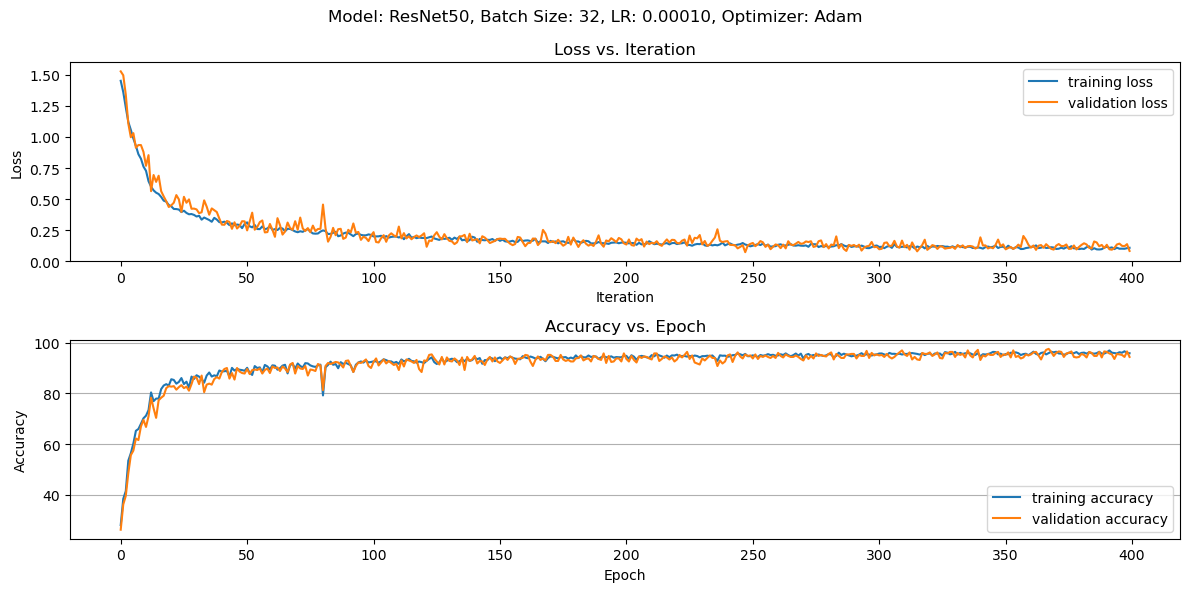

In [17]:
# Plot Learning Curves
ML.plot_learning_curve(hist)

In [18]:
print('last validation data accuracy', hist['validation_accuracy'][-1])

last validation data accuracy 94.42231075697211


In [19]:
print('highest validation accuracy achieved: ' , max(hist['validation_accuracy']))

highest validation accuracy achieved:  97.60956175298804


In [20]:
hist['validation_accuracy'].index(max(hist['validation_accuracy']))

367

In [21]:
predictions, test_labels = ML.predict(model=model, test_loader=test_loader, device=device)

  0%|          | 0/63 [00:00<?, ?batch/s]

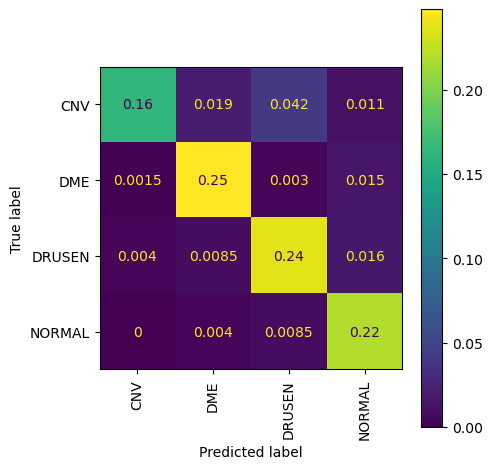

In [22]:
cm = confusion_matrix(test_labels, predictions, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(include_values=True, xticks_rotation='vertical', ax=ax)
plt.tight_layout()
plt.show()

In [23]:
print('test data accuracy: ', ML.test_accuracy(model=model, data_loader=test_loader, device=device))

  0%|          | 0/63 [00:00<?, ?batch/s]

test data accuracy:  86.71641791044776


In [29]:
##### LAST STEP, SAVE MODEL
path_model_save = 'model/resnet152_model_87p.pth'
torch.save(model.state_dict(), path_model_save)

**Fifth Step:** Inspecting the model's interpretability.

Source: 
- [2] https://jacobgil.github.io/pytorch-gradcam-book/Pixel%20Attribution%20for%20embeddings.html

In [25]:
import glob, random
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [26]:
def plot_samples(image_float, image_cam):

    fig, ax = plt.subplot_mosaic([
        ['image', 'cam']
    ], figsize=(15, 15))

    ax['image'].imshow(image_float)
    ax['image'].axis("off")

    ax['cam'].imshow(image_cam)
    ax['cam'].axis("off")

    plt.ioff()
    plt.show()

In [27]:
def get_rand_image_from_path(path):
    """A function that gets a random image in the path, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(random.choice(glob.glob(path + '*.jpeg'))))

    input_tensor = test_val_transform(img)
    img = input_tensor.numpy().transpose((1, 2, 0))

    img_min = np.min(img)
    img_max = np.max(img)
    rgb_img_float = (img - img_min) / (img_max  - img_min)    

    return img, rgb_img_float, input_tensor.unsqueeze(0)

In [30]:
path_model_save = 'model/resnet152_model_87p.pth'

loaded_model = models.resnet152()
loaded_model.fc = nn.Linear(in_features=2048, out_features=(len(classes)), bias=True)
loaded_model.load_state_dict(torch.load(path_model_save))
loaded_model.eval()

# model = ResnetFeatureExtractor(loaded_model)
model = loaded_model

In [31]:
def OCT_grad_cam(path_to_image, model, class_labels):

    # Set model to evaluation mode
    model.eval()

    # Initialize the random image
    img, img_float, img_tensor = get_rand_image_from_path(path_to_image)

    # Determine the confidence rate for the given prediction
    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)
    percentage = torch.nn.functional.softmax(output.data, dim=1)[0] * 100

    # Label the target layers for ResNet50
    target_layers = [model.layer4[-1]]

    # Obtain the concept features for the image based on the model
    img_targets = [ClassifierOutputTarget(predicted)]

    # Obtain the grayscale cam results for the image
    with GradCAM(model=model, target_layers=target_layers, use_cuda=False) as cam:

        img_grayscale_cam = cam(input_tensor= img_tensor, targets=img_targets,
                                aug_smooth=True, eigen_smooth=False)[0, :]

    # Obtain the cam image
    cam_image = show_cam_on_image(img_float, img_grayscale_cam, use_rgb=True)

    # Print the predicted label, the confidence level, and the images
    print('Class Predicted: ', class_labels[predicted[0]],'| Confidence Level: ', '%.2f' % percentage[predicted[0]].item())
    plot_samples(img_float, cam_image)

In [32]:
path_to_folder = './data/test/'
path_to_CNV = path_to_folder + 'CNV/'
path_to_DME = path_to_folder + 'DME/'
path_to_DRUSEN = path_to_folder + 'DRUSEN/'
path_to_NORMAL = path_to_folder + 'NORMAL/'

Class Predicted:  CNV | Confidence Level:  92.66


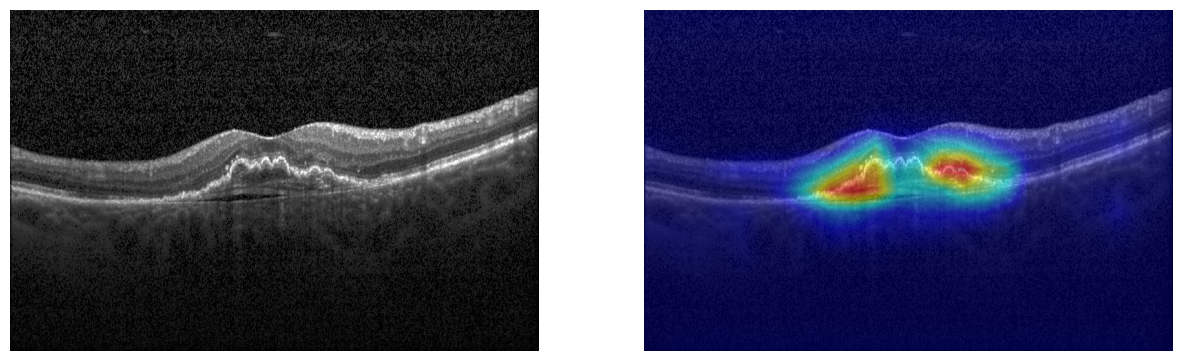

In [33]:
OCT_grad_cam(path_to_CNV, model, class_labels)

Class Predicted:  DME | Confidence Level:  62.64


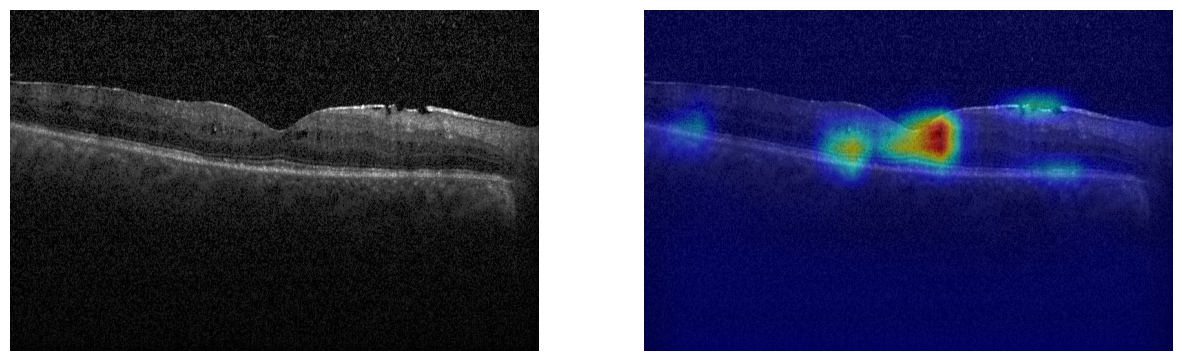

In [35]:
OCT_grad_cam(path_to_DME, model, class_labels)

Class Predicted:  DRUSEN | Confidence Level:  96.98


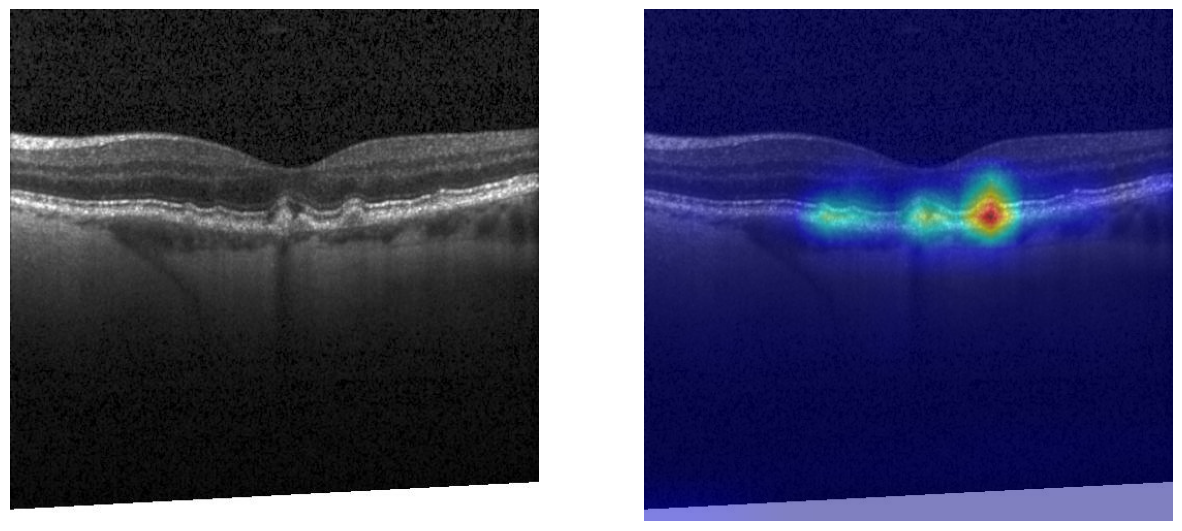

In [36]:
OCT_grad_cam(path_to_DRUSEN, model, class_labels)

Class Predicted:  NORMAL | Confidence Level:  99.28


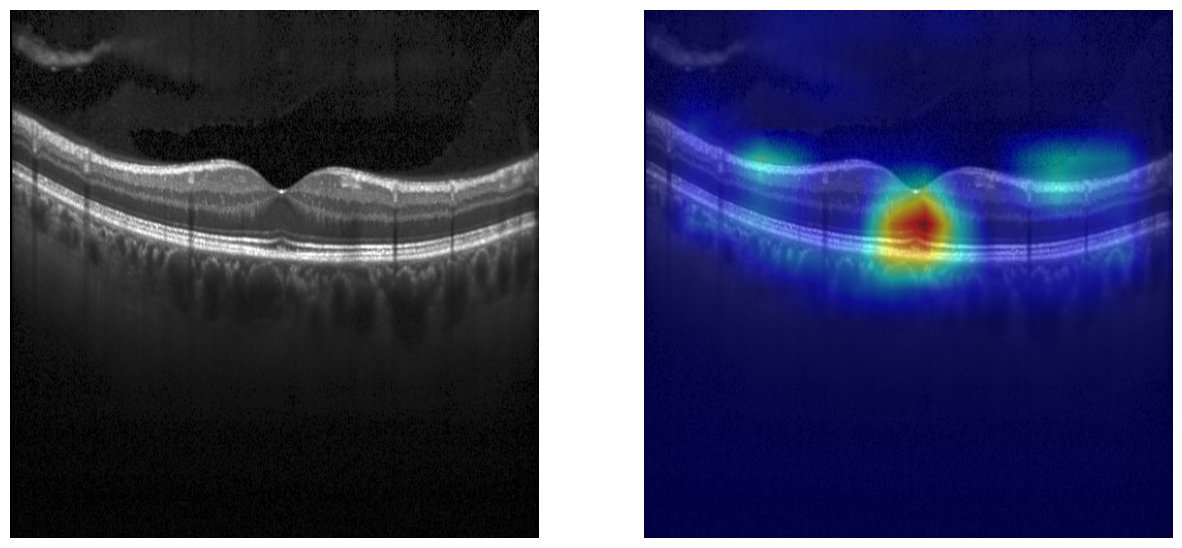

In [39]:
OCT_grad_cam(path_to_NORMAL, model, class_labels)

**Discussion**

For this mini-project I chose the following parameters:

- Train Data Transformations:
    - `RandomResizedCrop`
    - `RandomHorizontalFlip`
    - `GaussianBlur`
    - `ToTensor`
    - `Normalize`
        - Mean: [0.1977, 0.1977, 0.1977]
        - Std: [0.1048, 0.1048, 0.1048]

I selected `RandomResizedCrop` and `GaussianBlur` to augment the data with small changes in the batched sets to overcome any potential overfitting. RandomHorizontalFlip was introduced to further augment the data by having the image be interpreted as either the left or the right eye.
The `Normalize` parameters were obtained in `data_normalization.ipynb` by obtaining the mean and standard deviation of the training set. The mean and standard deviation for the training set were also applied to the validation and test sets.


- Batch Size: 
    -	32

After some experimentation, I found that a batch size of 32 was large enough to reduce the training time, but small enough to prevent the model from over generalizing, thus preventing underfitting.

- Model: 
    -	`ResNet152`
        - Final Layer (`model.fc`):
            - `in_features`: 2048
            - `out_features`: 4

I originally experimented with both ResNet18 and ResNet50 due to their compatibility with Grad-Cam and my prior experience with ResNet. This time I opted to go with ResNet152 due to the increase in the number of layers provided. I chose not to used pre-initialized weights because the models had been trained to identify a dataset that was not within the same scope as our OCT dataset, so each model was initialized without pre-trained weights. 

- Optimizer: 
    -	`Adam`
    -	Learning Rate (`lr`): 
        - 0.0001
- Loss Function (`loss_function`):  
    -	`CrossEntropyLoss`
- K-Folds: 
    -	10
- Epochs per Fold: 
    -	40


The final push for the training came through experimentation with the number of folds, epochs per fold, and the various transformations applied to the training dataset. Initially I attempted 5-folds with 10-epochs per fold (50 epochs total) on ResNet18 with the above transformations plus `ElasticTransform` and `RandomVerticalTransform`. The `ElasticTransform` tended to slowdown the training time and didn’t really improve the accuracy of the model on the test dataset, so that was removed. `RandomVerticalTransform` also had varying results but was removed in the end due to low returns on test dataset accuracy. 

With the folds, I found that 10 folds resulted in smoother learning curves and increasing the epochs to 40 per fold helped the model achieve +90% accuracy across each fold before moving to the next. ResNet18 was able to achieve 95% – 97% accuracy for training and validation, but only got as high as 85% for the test dataset accuracy. After switching to ResNet50, I was able to achieve 87% accuracy on the test dataset, with ResNet152 acheiving the same score. This is most likely due to the deeper layers on ResNet50 and ResNet152. The deeper layers helped the model capture the complexity of the data that correlated with each class. However, the accuracy didn't improve between ResNet50 and ResNet152 despite the magnitude of difference between the number of layers. This may be due to various factors, including the class imbalance within the datasets. The confusion matrix demonstrated that DME and DRUSEN were the easiest classes to identify, while Normal and CNV had lower performance.

Utilizing Grad-Cam, I was able to observe the regions that were used to classify the images. Images were randomly selected from each of the class folders under `test` and loaded through grad-cam. The grad-cam images displayed that the model was highlighting similar areas used for classification as those displayed in the presentation slides. For DME, it seemed to also put some importance on the artifacts found around the main object as an indicator of DME.

# References

- [1] https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/
- [2] https://jacobgil.github.io/pytorch-gradcam-book/Pixel%20Attribution%20for%20embeddings.html
- [3] https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
- [4] https://machinelearningmastery.com/use-pytorch-deep-learning-models-with-scikit-learn/